In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits

In [2]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# Silence an annoying warning that I get when running pd.read_excel
import warnings
warnings.filterwarnings("ignore", message="Data Validation extension is not supported and will be removed")

# Load sites and permits DataFrames for each city

In [5]:
# Load this once, to speed up load_site_inventory below
sites_df = utils.load_all_sites()

In [6]:
all_cities = sites_df.jurisdict.unique()

In [7]:
len(all_cities)

108

In [8]:
# Load this once, to speed up load_all_new_building_permits below
abag_permits_df = utils.load_abag_permits()

In [80]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [83]:
%%time
cities_with_sites = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_sites[city] = utils.load_site_inventory(city, sites_df=sites_df)
            cities_with_sites[city].relcapcty.sum()
        except Exception:
            pass

CPU times: user 7.36 s, sys: 202 ms, total: 7.56 s
Wall time: 7.71 s


In [84]:
len(cities_with_sites)

108

In [11]:
%%time
cities_with_permits = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_permits[city] = utils.load_all_new_building_permits(city, abag_permits_df)
        except Exception:
            print(city, file=sys.stderr)

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
Contra Costa County
Alameda County
Corte Madera
Marin County
Pleasant Hill
Saint Helena
Napa County
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
Hillsborough
San Mateo County
Sonoma County


CPU times: user 5min 24s, sys: 9.11 s, total: 5min 33s
Wall time: 5min 45s


Solano County


In [18]:
len(cities_with_permits)

97

In [19]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [20]:
def get_results_for_city(city: str, match_by: str) -> pd.DataFrame:
    permits = cities_with_permits[city]
    sites = cities_with_sites[city]
    
    nonvacant_matches, nonvacant_sites, nonvacant_ratio = utils.calculate_pdev_for_nonvacant_sites(sites, permits, match_by)
    vacant_matches, vacant_sites, vacant_ratio = utils.calculate_pdev_for_vacant_sites(sites, permits, match_by)
    all_matches, all_sites, all_ratio = utils.calculate_pdev_for_inventory(sites, permits, match_by)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': nonvacant_ratio,
        'P(dev) for vacant sites': vacant_ratio,
        'P(dev) for inventory': all_ratio,
        '# nonvacant matches': f'{nonvacant_matches} / {nonvacant_sites}',
        '# vacant matches': f'{vacant_matches} / {vacant_sites}',
        '# matches': f'{all_matches} / {all_sites}',
    }

In [21]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [22]:
len(cities)

97

In [86]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [87]:
%%time
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city, match_by='apn') for city in cities])

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape

CPU times: user 9.54 s, sys: 1.59 s, total: 11.1 s
Wall time: 11.9 s


/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


In [88]:
results_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.012,0.025,0.020,2 / 167,6 / 237,8 / 404
1,Albany,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41
2,Alameda,0.535,NaN,0.000,0.000,0.000,0.000,0 / 7,0 / 11,0 / 18
3,Livermore,0.577,1.238,0.245,0.071,0.165,0.119,7 / 99,17 / 103,24 / 202
4,Fremont,0.876,0.438,0.112,0.028,0.048,0.031,4 / 141,1 / 21,5 / 162
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.083,0.083,0.083,2 / 24,3 / 36,5 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.026,0.023,0 / 9,2 / 77,2 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [ ]:
%%time
with HiddenPrints():
    results_geo_df = pd.DataFrame([get_results_for_city(city, match_by='geo') for city in cities])

In [35]:
results_geo_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.030,0.034,0.032,5 / 167,8 / 237,13 / 404
1,Albany,0.634,NaN,0.000,0.091,0.125,0.098,3 / 33,1 / 8,4 / 41
2,Alameda,0.535,NaN,0.000,0.286,0.273,0.278,2 / 7,3 / 11,5 / 18
3,Livermore,0.577,1.238,0.245,0.071,0.272,0.173,7 / 99,28 / 103,35 / 202
4,Fremont,0.651,0.756,0.148,0.317,0.095,0.297,66 / 208,2 / 21,68 / 229
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.042,0.111,0.083,1 / 24,4 / 36,5 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [36]:
%%time
with HiddenPrints():
    results_both_df = pd.DataFrame([get_results_for_city(city, match_by='both') for city in cities])

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape

CPU times: user 1min 36s, sys: 6.06 s, total: 1min 42s
Wall time: 1min 45s


In [37]:
results_both_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.030,0.034,0.032,5 / 167,8 / 237,13 / 404
1,Albany,0.634,NaN,0.000,0.091,0.125,0.098,3 / 33,1 / 8,4 / 41
2,Alameda,0.535,NaN,0.000,0.286,0.273,0.278,2 / 7,3 / 11,5 / 18
3,Livermore,0.577,1.238,0.245,0.101,0.282,0.193,10 / 99,29 / 103,39 / 202
4,Fremont,0.651,0.756,0.148,0.332,0.095,0.310,69 / 208,2 / 21,71 / 229
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.083,0.139,0.117,2 / 24,5 / 36,7 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


<AxesSubplot:>

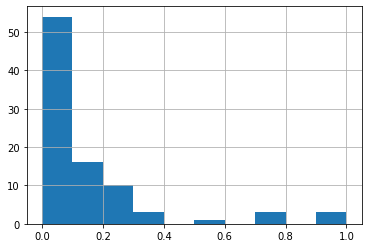

In [38]:
results_both_df['P(dev) for nonvacant sites'].hist()

In [39]:
combined_df = results_df.merge(
    results_geo_df,
    on='City',
    suffixes=[' (by APN)', ' (by geomatching)']
)

In [40]:
combined_df.round(3)

,City,Ratio of development on inventory sites (by APN),Mean overproduction (by APN),Inventory housing / all housing (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Ratio of development on inventory sites (by geomatching),Mean overproduction (by geomatching),Inventory housing / all housing (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
0,Berkeley,0.348,1.255,0.041,0.012,0.025,0.020,2 / 167,6 / 237,8 / 404,0.348,1.255,0.041,0.030,0.034,0.032,5 / 167,8 / 237,13 / 404
1,Albany,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41,0.634,NaN,0.000,0.091,0.125,0.098,3 / 33,1 / 8,4 / 41
2,Alameda,0.535,NaN,0.000,0.000,0.000,0.000,0 / 7,0 / 11,0 / 18,0.535,NaN,0.000,0.286,0.273,0.278,2 / 7,3 / 11,5 / 18
3,Livermore,0.577,1.238,0.245,0.071,0.165,0.119,7 / 99,17 / 103,24 / 202,0.577,1.238,0.245,0.071,0.272,0.173,7 / 99,28 / 103,35 / 202
4,Fremont,0.651,0.756,0.148,0.067,0.048,0.066,14 / 208,1 / 21,15 / 229,0.651,0.756,0.148,0.317,0.095,0.297,66 / 208,2 / 21,68 / 229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.083,0.083,0.083,2 / 24,3 / 36,5 / 60,0.511,0.279,0.028,0.042,0.111,0.083,1 / 24,4 / 36,5 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.026,0.023,0 / 9,2 / 77,2 / 86,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [41]:
results_df.to_csv('results/apn_matching_results.csv')
results_geo_df.to_csv('results/geo_matching_results.csv')
combined_df.to_csv('results/combined_df.csv')
results_both_df.to_csv('results/apn_or_geo_matching_results.csv')

Let's look into some cities where the APN results and Geo results are very out of line:

In [45]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by APN)'] - combined_df['P(dev) for nonvacant sites (by geomatching)']).abs() > 0.3
]

,City,Ratio of development on inventory sites (by APN),Mean overproduction (by APN),Inventory housing / all housing (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Ratio of development on inventory sites (by geomatching),Mean overproduction (by geomatching),Inventory housing / all housing (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
7,Brentwood,0.717036,1.208451,0.157779,0.290640,0.006061,0.256688,354 / 1218,1 / 165,355 / 1383,0.717036,1.208451,0.157779,0.771757,0.109091,0.692697,940 / 1218,18 / 165,958 / 1383
18,San Francisco,0.552246,NaN,0.266158,1.000000,1.000000,1.000000,4618 / 4618,1540 / 1540,6158 / 6158,0.552246,NaN,0.266158,0.074924,0.075974,0.075187,346 / 4618,117 / 1540,463 / 6158
48,San Bruno,0.463822,0.426667,0.128000,0.333333,NaN,0.333333,2 / 6,0 / 0,2 / 6,0.463822,0.426667,0.128000,0.000000,NaN,0.000000,0 / 6,0 / 0,0 / 6
57,Colma,2.884615,2.538462,0.880000,1.000000,NaN,1.000000,1 / 1,0 / 0,1 / 1,2.884615,2.538462,0.880000,0.000000,NaN,0.000000,0 / 1,0 / 0,0 / 1
62,Foster City,0.401995,NaN,0.000000,0.750000,NaN,0.750000,3 / 4,0 / 0,3 / 4,0.401995,NaN,0.000000,0.000000,NaN,0.000000,0 / 4,0 / 0,0 / 4
63,Portola Valley,0.585185,1.375000,0.139241,0.000000,0.105263,0.102564,0 / 2,8 / 76,8 / 78,0.585185,1.375000,0.139241,1.000000,0.118421,0.141026,2 / 2,9 / 76,11 / 78
96,Windsor,0.157109,2.000000,0.385000,0.125000,0.000000,0.115385,6 / 48,0 / 4,6 / 52,0.157109,2.000000,0.385000,0.541667,0.000000,0.500000,26 / 48,0 / 4,26 / 52


In [48]:
cities_with_sites['Brentwood']

,objectid,apn,locapn,genplan,zoning,gacres,locacres,allowden,relcapcty,desafford,...,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry,index
236,42370,16440057,16440057,R-LD,PD-45,0.165,0.165491,NaN,1.0,NaN,...,NaN,Approved,NaN,NaN,Cedarwood,NaN,6.864866e-08,0.001066,"POLYGON ((-121.69001 37.94233, -121.68979 37.9...",0
20754,62888,16530010,16530010,R-LD,PD-46,0.192,0.192137,NaN,1.0,NaN,...,NaN,Approved,NaN,NaN,Barrington,NaN,7.971221e-08,0.001130,"POLYGON ((-121.68481 37.94894, -121.68481 37.9...",1
20802,62936,16490018,16490018,R-LD,PD-46,0.131,0.130848,NaN,1.0,NaN,...,NaN,Approved,NaN,NaN,Barrington,NaN,5.428501e-08,0.001007,"POLYGON ((-121.68993 37.94912, -121.68993 37.9...",2
20989,63123,16490007,16490007,R-LD,PD-46,0.131,0.130848,NaN,1.0,NaN,...,NaN,Approved,NaN,NaN,Barrington,NaN,5.428501e-08,0.001007,"POLYGON ((-121.68959 37.94847, -121.68960 37.9...",3
21343,63477,16490011,16490011,R-LD,PD-46,0.131,0.130841,NaN,1.0,NaN,...,NaN,Approved,NaN,NaN,Barrington,NaN,5.428228e-08,0.001007,"POLYGON ((-121.68959 37.94912, -121.68959 37.9...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37478,79612,13132005,13132005,DSP,DT,0.385,0.385102,NaN,0.0,NaN,...,NaN,Vacant,NaN,NaN,NaN,NaN,1.597286e-07,0.001686,"POLYGON ((-121.69387 37.93006, -121.69437 37.9...",1378
37479,79613,13132004,13132004,DSP,DT,0.210,0.210453,NaN,0.0,NaN,...,NaN,Vacant,NaN,NaN,NaN,NaN,8.728875e-08,0.001344,"POLYGON ((-121.69407 37.93028, -121.69452 37.9...",1379
37480,79614,19081009,19081009,MUPT,PD-53,9.886,9.889850,NaN,0.0,NaN,...,NaN,Vacant,NaN,NaN,NaN,NaN,4.103008e-06,0.009355,"POLYGON ((-121.74158 37.95067, -121.74160 37.9...",1380
37481,79615,19020071,19020071,MUPT,PD-53,7.517,7.519910,NaN,0.0,NaN,...,NaN,Vacant,NaN,NaN,NaN,NaN,3.120242e-06,0.008041,"POLYGON ((-121.74359 37.95890, -121.74360 37.9...",1381


In [51]:
cities_with_sites['Brentwood']['sitetype'].value_counts()

Approved         1193
Vacant            165
Underutilized      25
Name: sitetype, dtype: int64

In [56]:
sites_df['sitetype'].value_counts(dropna=False)

Underutilized           16385
Vacant                  13541
NaN                      8027
Approved                 2908
Built                     746
Under Consideration       166
Entitled                  103
Opportunity                62
Non-Vacant                 51
Underutilized and Va       44
Infill                     23
Pending                    17
Proposed                   12
Planned and Approved       11
Undeveloped                 9
Underutilized, margi        6
Underused site              6
Open Space                  4
Planned                     4
Vacant and Underutil        2
underutilize                1
Limited access              1
Under Construction          1
PDA                         1
Under consideration         1
Underutilized & Vaca        1
Name: sitetype, dtype: int64

In [49]:
cities_with_permits['Brentwood']

,objectid,joinid,permyear,county,jurisdictn,apn,address,zip,projname,hcategory,...,Building Permits Date Issued,How many of the units were Extremely Low Income?+,Was Project APPROVED using GC 65913.4(b)? (SB 35 Streamlining) Y/N,Infill Units? Y/N+,Deed Restriction Type (see instructions),"For units affordable without financial assistance or deed restrictions, explain how the locality determined the units were affordable (see instructions)",Term of Affordability or Deed Restriction (years) (if affordable in perpetuity enter 1000)+,Number of Demolished/Destroyed Units+,Demolished or Destroyed Units+,Demolished/Destroyed Units Owner or Renter+
0,NaN,f1c785c0-726c-11e8-adc0-fa7ae01bbebc,2017,6013.0,Brentwood,17690061.0,1016 Ginger Ct,94513,Pulte,SF,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,f1c787aa-726c-11e8-adc0-fa7ae01bbebc,2017,6013.0,Brentwood,17690062.0,1014 Ginger Ct,94513,Pulte,SF,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,f1c78b7e-726c-11e8-adc0-fa7ae01bbebc,2017,6013.0,Brentwood,17690063.0,1012 Ginger Ct,94513,Pulte,SF,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,f1c78cf0-726c-11e8-adc0-fa7ae01bbebc,2017,6013.0,Brentwood,7680034.0,1925 Barbaresco Ln,94513,Shea,SF,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,f1c78e12-726c-11e8-adc0-fa7ae01bbebc,2017,6013.0,Brentwood,12370036.0,177 Avery Ct,94513,Seeno,SF,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2684,NaN,NaN,2016,NaN,NaN,16510045.0,310 HAMPSTEAD DR,NaN,NaN,SFD,...,2016-02-26,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN
2685,NaN,NaN,2016,NaN,NaN,16510046.0,308 HAMPSTEAD DR,NaN,NaN,SFD,...,2016-02-26,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN
2686,NaN,NaN,2017,NaN,NaN,16550005.0,32 HAVENWOOD,NaN,NaN,SFD,...,2017-09-15,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN
2687,NaN,NaN,2017,NaN,NaN,16550033.0,7147 BRENTWOOD BLVD,NaN,NaN,SFA,...,2017-09-15,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] >= combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.845360824742268
P(dev) for vacant sites 0.7938144329896907
P(dev) for inventory 0.8969072164948454


In [46]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] == combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.27835051546391754
P(dev) for vacant sites 0.25773195876288657
P(dev) for inventory 0.17525773195876287


# "Ground truth" data

In [667]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }

In [672]:

permits = pd.read_csv("./data/raw_data/sf_permits.csv")
print(permits.columns)
date_cols = [c for c in permits.columns if 'Date' in c]
permits[date_cols] = permits[date_cols].apply(pd.to_datetime)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [673]:
print(permits.columns)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [685]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

Dropping constant columns: ['county', 'num_vl', 'rhnayrs', 'rhnacyc', 'infcapcty', 'allowlow', 'jurisdict', 'num_m', 'num_am', 'num_l']
DF shape (57, 25)
Total units permitted: 532
Total realistic capacity in inventory: 257.5
Number of inventory sites developed: 9
Number of units permitted on inventory sites: 34
Total realistic capacity of inventory sites: 38.0
Units permitted on inventory sites: 34
Total units permitted: 532
Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


KeyError: 'Block'

In [684]:
ground_truth_results_df

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory
0,Los Altos,2.066019,-0.444444,0.06391,0.088235,0.26087,0.157895
